In [5]:
import maxent as me
import jax.numpy as jnp
from jax import grad, jit, vmap, jacfwd, jacrev
from jax import random
import jax.scipy.sparse as sp
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from tqdm.auto import tqdm, trange
from scipy.sparse import csc_matrix

In [67]:
import observables as obs
import imp
imp.reload(obs)


<module 'observables' from '/Users/reema/Postdoc/Progetti/MAXENT/MAXENT/observables.py'>

In [145]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [68]:
import imp
imp.reload(me)

<module 'maxent' from '/Users/reema/Postdoc/Progetti/MAXENT/MAXENT/maxent.py'>

In [71]:

N = 1000
ba = nx.barabasi_albert_graph(N,30)
gn = nx.scale_free_graph(1000)
g = ba
adj = np.asarray(nx.adj_matrix(g).todense())
d = np.array(adj.sum(axis=0)).flatten()
dinv = 1/d

din = np.array(adj.sum(axis=0)).flatten()
dout = np.array(adj.sum(axis=1)).flatten()

def get_din_dout(g):
    adj = np.asarray(nx.adj_matrix(g).todense())
    din = np.array(adj.sum(axis=0)).flatten()
    dout = np.array(adj.sum(axis=1)).flatten()
    return din,dout



In [9]:

x = np.zeros(N)
x[np.random.randint(0,N, int(N/100*20))] = 1
#x = np.random.rand(N)
x= x/x.sum()
x = jnp.asarray(x)

lambd = 0.1
def propagate(adj,x,lambd=lambd):
    p = adj / jnp.reshape(adj.sum(axis=0), [adj.shape[0],1])
    I = jnp.eye(p.shape[0])
    return lambd*x.dot(jnp.linalg.inv(I - (1-lambd)*p))


lambd = 0.1
def propagate2(adj,x,i,lambd=lambd):
    p = adj / jnp.reshape(adj.sum(axis=0), [adj.shape[0],1])
    I = jnp.eye(p.shape[0])
    return lambd*x.dot(jnp.linalg.inv(I - (1-lambd)*p))[i]

# Jax

In [43]:
def func(adj,x,lambd,i=None):
    p = adj / jnp.reshape(adj.sum(axis=0), [adj.shape[0], 1])
    I = jnp.eye(p.shape[0])
    if i is None:
        return lambd*x.dot(jnp.linalg.inv(I - (1-lambd)*p))
    else:
        e = np.zeros(adj.shape[0])
        e[i] = 1
        yi = lambd * jnp.linalg.solve((I - (1-lambd)*p),e)
        return (yi*x).sum()

In [44]:
propagate2(adj,x,0,lambd)

DeviceArray(0.00174562, dtype=float32)

In [47]:
[(func(adj,x,lambd,i),propagate2(adj,x,i,lambd)) for i in trange(adj.shape[0])]

[(DeviceArray(0.00174562, dtype=float32),
  DeviceArray(0.00174562, dtype=float32)),
 (DeviceArray(0.00165213, dtype=float32),
  DeviceArray(0.00165214, dtype=float32)),
 (DeviceArray(0.0014084, dtype=float32),
  DeviceArray(0.0014084, dtype=float32)),
 (DeviceArray(0.00111997, dtype=float32),
  DeviceArray(0.00111997, dtype=float32)),
 (DeviceArray(0.00221709, dtype=float32),
  DeviceArray(0.00221709, dtype=float32)),
 (DeviceArray(0.00011373, dtype=float32),
  DeviceArray(0.00011373, dtype=float32)),
 (DeviceArray(0.00195408, dtype=float32),
  DeviceArray(0.00195408, dtype=float32)),
 (DeviceArray(0.00168277, dtype=float32),
  DeviceArray(0.00168277, dtype=float32)),
 (DeviceArray(0.00193614, dtype=float32),
  DeviceArray(0.00193614, dtype=float32)),
 (DeviceArray(0.00093249, dtype=float32),
  DeviceArray(0.00093249, dtype=float32)),
 (DeviceArray(0.00167985, dtype=float32),
  DeviceArray(0.00167985, dtype=float32)),
 (DeviceArray(0.00224542, dtype=float32),
  DeviceArray(0.00224542,

# ANND

In [70]:
def annd(adj,i=None):
    if i is None:
        return adj.dot(adj).sum(axis=1) / adj.sum(axis=1)
    else:
        return adj[i,:].dot(adj).sum() / adj[i,:].sum()

In [71]:
annd(adj,0)

94.58219178082192

In [67]:
annd(adj)

array([ 94.58219178,  91.17391304, 101.80733945,  91.13265306,
        86.26315789,  92.37113402,  92.76027397, 114.52941176,
       103.30434783,  99.29761905,  94.66666667, 100.57142857,
        88.24836601,  99.825     ,  90.06766917,  92.48979592,
        85.45      ,  87.375     ,  91.84466019,  83.62068966,
        86.85123967,  97.61797753,  97.03846154,  92.05797101,
        88.51181102,  90.5234375 ,  98.05      ,  88.17293233,
        87.90825688,  85.05882353,  83.76056338,  84.36226415,
        83.51984127,  80.74013158,  82.275     ,  87.59090909,
        85.81549815,  82.83643123,  86.55605381,  83.81696429,
        88.52631579,  84.05555556,  83.87336245,  82.696     ,
        86.73214286,  87.73366834,  85.69651741,  86.90049751,
        92.53107345,  88.10106383,  86.66477273,  89.60893855,
        90.92647059,  81.26865672,  83.71764706,  86.74      ,
        87.64285714,  88.81132075,  85.15853659,  87.89440994,
        82.4619883 ,  81.82738095,  78.73006135,  85.37

In [43]:
def annd_sparse(adj,i=None):
    return np.asarray(adj.dot(adj).sum(axis=1) / adj.sum(axis=1))[:,0]

# Ensemble

In [146]:
imp.reload(obs)
imp.reload(me)
m = me.GraphEnsemble(1000)
#m.fit([me.DegreeSequence(get_din_dout(ba)[0])], opt_kwargs={'nit':100,'fatol':1e-2})
#m.fit([me.DegreeSequence(get_din_dout(ba)[0]),me.Connectivity(250, nodeset1=np.arange(30), nodeset2=np.arange(40,50))], opt_kwargs={'nit':100,'fatol':1e-2})
m.fit([me.DegreeSequence(get_din_dout(ba)[0][:30], nodeset=np.arange(30))], opt_kwargs={'nit':100,'fatol':1e-2})




0:  |F(x)| = 99.4524; step 1
1:  |F(x)| = 37.0528; step 1
2:  |F(x)| = 78.0385; step 1
3:  |F(x)| = 14.0187; step 1
4:  |F(x)| = 13.5786; step 1
5:  |F(x)| = 8.58062; step 1
6:  |F(x)| = 2.2142; step 1
7:  |F(x)| = 1.59421; step 0.135435
8:  |F(x)| = 0.885601; step 1
9:  |F(x)| = 0.114671; step 1
10:  |F(x)| = 0.0956498; step 1
11:  |F(x)| = 0.0127388; step 1
12:  |F(x)| = 0.00954938; step 1
13:  |F(x)| = 0.00322864; step 1
14:  |F(x)| = 0.00150098; step 1
15:  |F(x)| = 0.000793111; step 1
16:  |F(x)| = 0.000308751; step 1
17:  |F(x)| = 0.000187915; step 1
18:  |F(x)| = 3.88095e-05; step 1
19:  |F(x)| = 2.96986e-05; step 1
20:  |F(x)| = 8.33918e-06; step 1
21:  |F(x)| = 5.06821e-06; step 1
22:  |F(x)| = 1.56458e-06; step 1
23:  |F(x)| = 1.07873e-06; step 1
24:  |F(x)| = 9.77609e-07; step 1
25:  |F(x)| = 7.71472e-07; step 1
26:  |F(x)| = 1.86523e-07; step 1
27:  |F(x)| = 1.24876e-07; step 1
28:  |F(x)| = 6.37488e-08; step 1
29:  |F(x)| = 4.36951e-08; step 1
30:  |F(x)| = 1.38694e-08; st

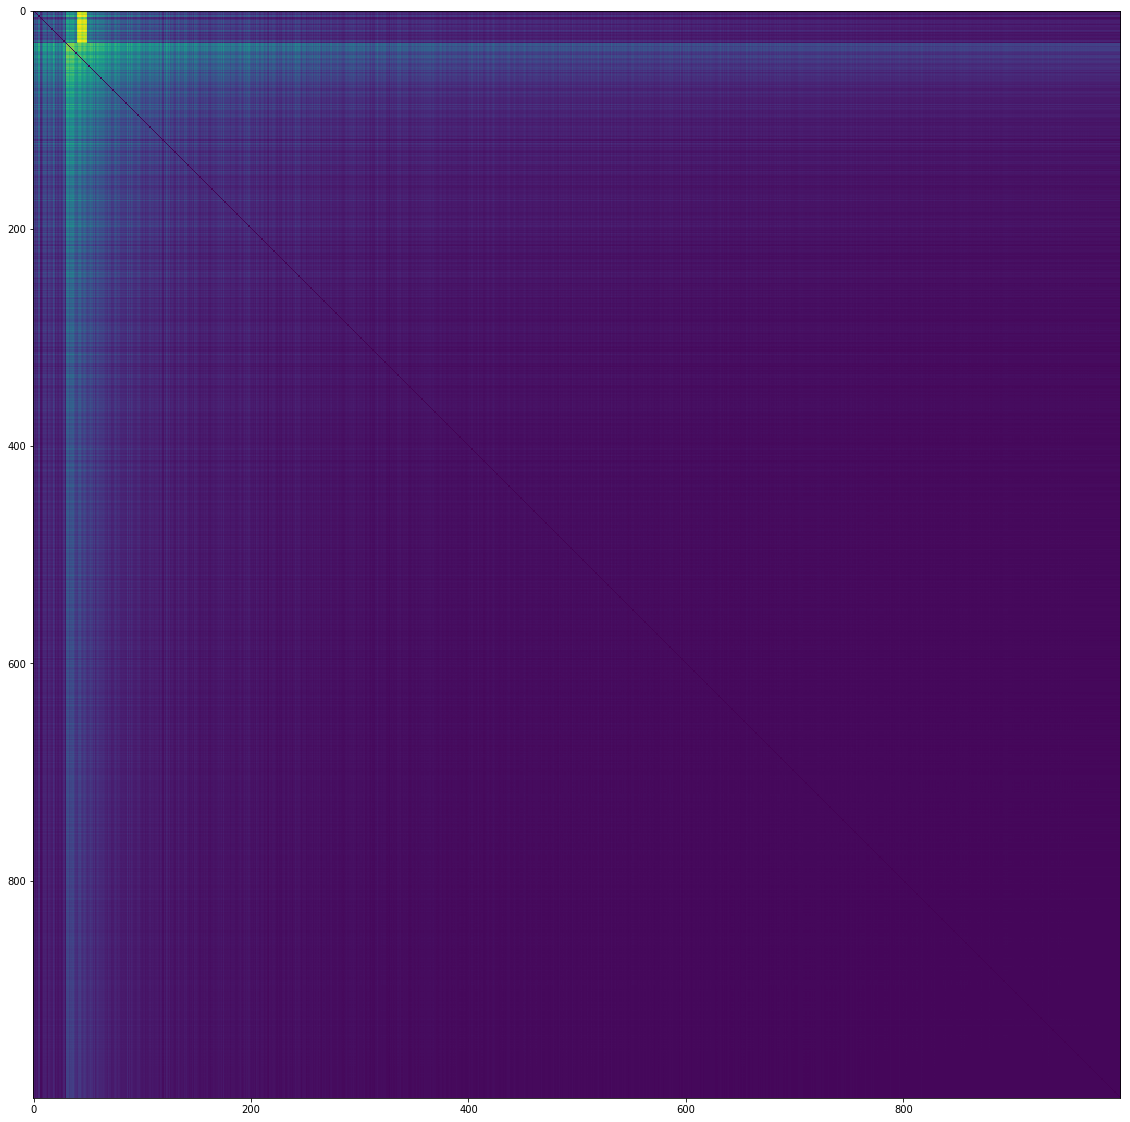

In [144]:
plt.figure(figsize=[20,20])
plt.imshow(m.adj_matrix)

In [64]:
#mu = m.predict_mean(propagate, f_args=[x, lambd])
#mu = m.predict_mean(annd)
#mu = m.predict_mean(obs.RandomWalkWithRestart.func, f_args=[x, lambd])
mu = m.predict_mean(obs)

In [65]:
#sigma = [m.predict_std(grad(propagate2, argnums=0), f_args=[x,i, lambd]) for i in trange(N)]
#sigma = [m.predict_std(grad(annd, argnums=0), f_args=[i]) for i in trange(N)]
sigma = m.predict_std(obs.RandomWalkWithRestart.grad, f_args=[x, lambd], batch_size=10)

In [142]:
np.mean([m.sample()[np.arange(30)[:,None], np.arange(40,50)].sum() for _ in range(100)] )

249.85

In [153]:
degdists = np.asarray([m.sample().sum(axis=1) for i in trange(100)])

In [159]:
np.array([2,3,4,5,6])[slice(None)]

array([2, 3, 4, 5, 6])

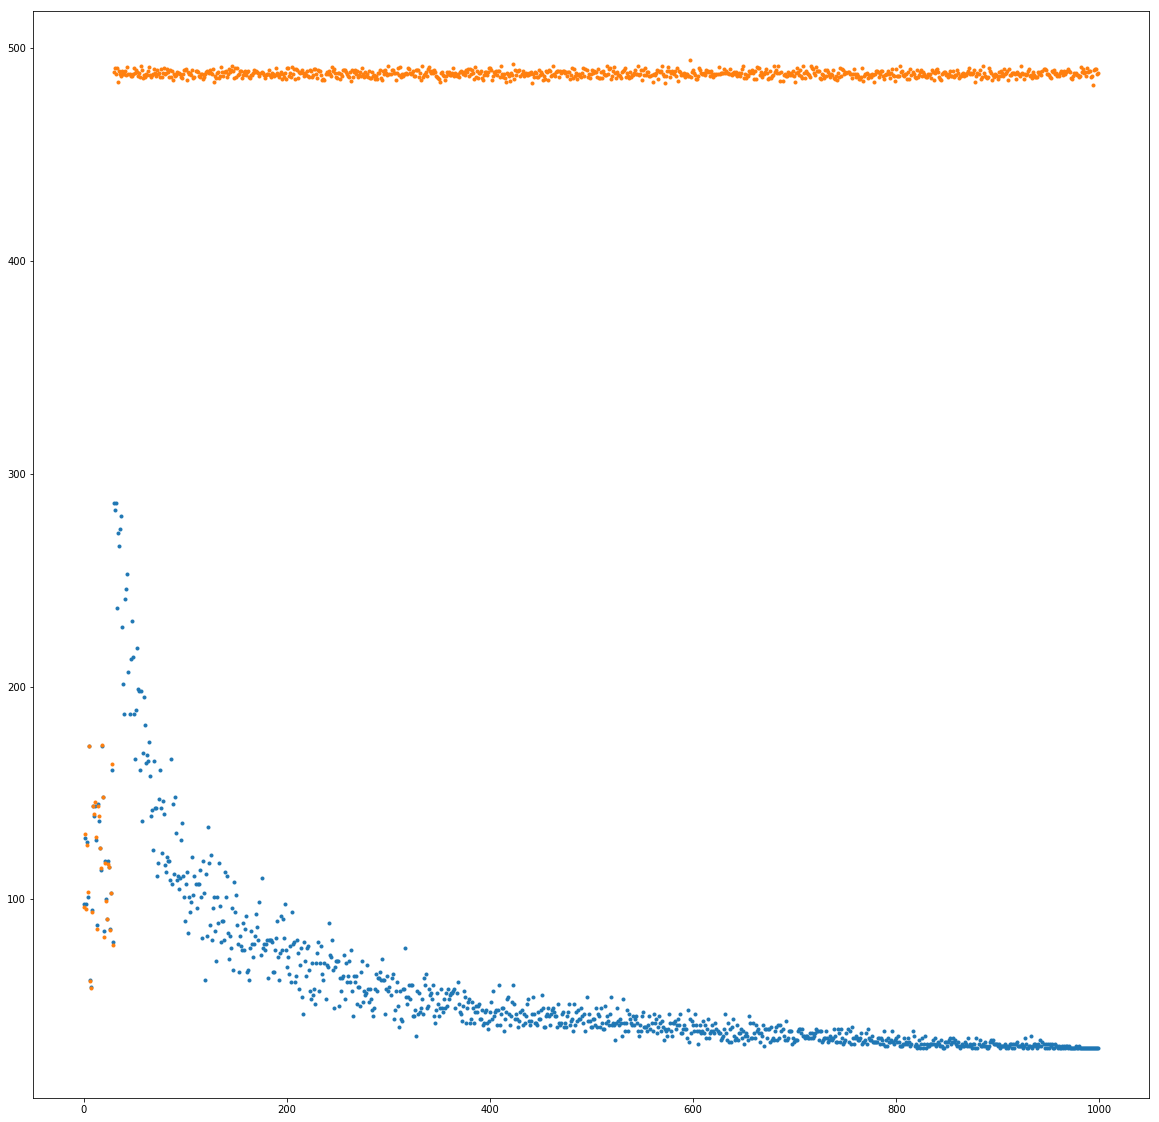

In [158]:
plt.figure(figsize=[20,20])
plt.plot(get_din_dout(ba)[0],'.')
plt.plot(degdists.mean(axis=0),'.')

In [152]:
for i in range(5):
    print(list(zip(list(range(1000)),m.sample().sum(axis=1),get_din_dout(ba)[0]))[:50])
    print()

[(0, 112, 98), (1, 143, 129), (2, 87, 98), (3, 139, 127), (4, 93, 101), (5, 159, 172), (6, 58, 62), (7, 55, 59), (8, 109, 95), (9, 145, 144), (10, 111, 139), (11, 125, 144), (12, 132, 128), (13, 97, 88), (14, 161, 145), (15, 161, 137), (16, 118, 124), (17, 109, 114), (18, 167, 172), (19, 144, 148), (20, 76, 85), (21, 121, 118), (22, 113, 100), (23, 94, 91), (24, 114, 118), (25, 117, 115), (26, 82, 86), (27, 110, 103), (28, 184, 161), (29, 67, 80), (30, 480, 286), (31, 489, 283), (32, 475, 286), (33, 476, 237), (34, 485, 272), (35, 519, 266), (36, 486, 274), (37, 470, 280), (38, 488, 228), (39, 470, 201), (40, 494, 187), (41, 468, 241), (42, 484, 246), (43, 488, 253), (44, 495, 207), (45, 487, 187), (46, 497, 213), (47, 474, 231), (48, 478, 214), (49, 517, 187)]

[(0, 121, 98), (1, 132, 129), (2, 91, 98), (3, 129, 127), (4, 95, 101), (5, 158, 172), (6, 69, 62), (7, 58, 59), (8, 100, 95), (9, 149, 144), (10, 146, 139), (11, 156, 144), (12, 131, 128), (13, 81, 88), (14, 160, 145), (15, 13

In [134]:
m.adj_matrix

array([[0.        , 0.23106053, 0.1774205 , ..., 0.05287781, 0.05287781,
        0.05287781],
       [0.23106053, 0.        , 0.23106053, ..., 0.07216797, 0.07216797,
        0.07216797],
       [0.1774205 , 0.23106053, 0.        , ..., 0.05287781, 0.05287781,
        0.05287781],
       ...,
       [0.05287781, 0.07216797, 0.05287781, ..., 0.        , 0.0142455 ,
        0.0142455 ],
       [0.05287781, 0.07216797, 0.05287781, ..., 0.0142455 , 0.        ,
        0.0142455 ],
       [0.05287781, 0.07216797, 0.05287781, ..., 0.0142455 , 0.0142455 ,
        0.        ]])

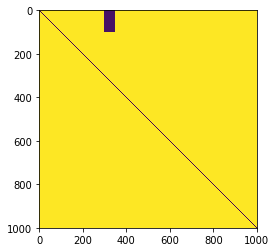

In [130]:
plt.imshow(m.adj_matrix)

# slice test

In [21]:
def grad(adj,x,lambd,bslice):
    dinv = 1/adj.sum(axis=1)
    p = adj * dinv[:,None]
    I = np.eye(p.shape[0])
    omega = lambd * x[None,:].dot(np.linalg.inv(I - (1 - lambd) * p))
    inv_term = np.eye(adj.shape[0])
    gradval = (1 - lambd) * dinv[:, None] * omega[0,:, None] * inv_term[None, :, bslice]
    return gradval

In [27]:
np.allclose(grad(m.adj_matrix,x,lambd,0),(1-lambd) * lambd * dinv[:,None] * omega[0,:,None] * np.eye(N)[None,:,0])

True

In [30]:
[np.allclose(grad(m.adj_matrix,x,lambd,i)*m.sigma, part_term * np.eye(N)[None,:,i]) for i in trange(N)]

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,

In [35]:
sigma[i]

0.00016858843446243554

In [45]:
grad(m.adj_matrix,x,lambd,i).shape

(1000, 1000)

In [46]:
m.sigma[...].shape

(1000, 1000)

In [51]:
grad(m.adj_matrix,x,lambd,slice(i,i+1)).shapea


(1, 1000, 1)

In [47]:
np.sqrt(((grad(m.adj_matrix,x,lambd,slice(i,i+1))*m.sigma[...,None])**2).sum(axis=[0,1]))

array([0.00016859], dtype=float32)

In [54]:
np.sqrt(((m.sigma * (1-lambd) * lambd * dinv[:,None] * omega[0,:,None] * np.eye(N)[None,:,slice(i,i+1)])**2).xsum(axis=[0,1]))

SyntaxError: unexpected EOF while parsing (<ipython-input-54-0c5eddd33579>, line 1)

In [61]:
(dinv[:,None]*np.eye(N)[None,:,i]).shape

(1000, 1000)

In [57]:
((m.sigma * (1-lambd) * lambd * dinv[:,None] * omega[0,:,None] * np.eye(N)[None,:,slice(i,i+1)])**2).shape

(1, 1000, 1000)

In [42]:
np.sqrt(((m.sigma * (1-lambd) * lambd * dinv[:,None] * omega[0,:,None] * np.eye(N)[None,:,i])**2).sum(axis=[0,1]))

0.00013776027

In [40]:
sigma_y_neu_0[i]

0.00013776027

In [ ]:
part_term * np.eye(N)[None,:,i]

In [31]:
np.all(_)

True

In [18]:

kappa = np.eye(N) - (1-lambd) * dinv[:,None] * m.adj_matrix

invm= np.linalg.inv(kappa)

maxent_k = lambd * invm

#sigma_y = np.zeros(N)
#omega = x[None,:].dot(invm)
#for n in trange(N):
#    term = (sigma_aij * (1-lambd) * lambd * dinv[:,None] * invm[None,:,n] * omega[0,:,None])**2
#    sigma_y[n] = np.sqrt(np.sum(term))

omega = x[None,:].dot(invm)

part_term = m.sigma * (1-lambd) * lambd * dinv[:,None] * omega[0,:,None]

def wrap(n):
    #inv_term = invm
    inv_term = np.eye(N)
    term = (part_term * inv_term[None,:,n])**2
    return np.sqrt(np.sum(term))
    

sigma_y_neu_0 = np.asarray(list(map(wrap, trange(N))))


# Random shit

In [18]:
grad_term = np.arange(11)
batch_size = 3
for b in trange(int(len(grad_term) / batch_size)+1):
    i0 = b*batch_size
    i1 = (b+1)*batch_size
    print(grad_term[i0:i1])

[0 1 2]
[3 4 5]
[6 7 8]
[ 9 10]



In [63]:
adj = np.asarray(nx.adj_matrix(ba).todense())


100%|██████████| 1000/1000 [00:03<00:00, 277.07it/s]


In [92]:
sigma

0.11852182699441972

In [74]:
sigma

[3.8635294,
 4.6621237,
 4.854453,
 5.2511477,
 4.6931353,
 5.29046,
 3.8635302,
 6.7754526,
 5.4963756,
 5.8625355,
 4.7886343,
 5.8625374,
 3.7175636,
 6.0654387,
 4.164529,
 5.2511477,
 6.0654397,
 4.5128517,
 5.0630884,
 3.885241,
 4.4840994,
 5.6280074,
 5.027084,
 4.043758,
 4.3187037,
 4.2922635,
 4.5128517,
 4.1645327,
 4.8544507,
 4.5419626,
 2.103559,
 2.255725,
 2.370686,
 1.9607592,
 2.1341608,
 2.2642365,
 2.2057574,
 2.2222075,
 2.6658409,
 2.654644,
 2.8314967,
 2.546921,
 2.599835,
 2.38924,
 2.6546438,
 2.9609804,
 2.9342775,
 2.9342778,
 3.2851396,
 3.1157146,
 3.3013444,
 3.2531457,
 4.091266,
 2.9342794,
 3.401618,
 3.7788608,
 3.436255,
 3.600226,
 3.507443,
 3.56259,
 3.3845336,
 3.4362562,
 3.5256562,
 3.9972546,
 3.3341823,
 3.10107,
 3.5625901,
 3.350818,
 4.3999157,
 3.4715252,
 4.3454533,
 3.9071736,
 4.214751,
 4.1398363,
 3.6002283,
 4.4556966,
 4.214751,
 3.1010704,
 3.4715257,
 3.3676007,
 4.214751,
 4.240293,
 3.4016223,
 5.2124166,
 4.5714417,
 4.991595

In [78]:
N_samples = 1000
y = np.asarray(annd(csc_matrix(adj))).flatten()
#samples = []
rdm_annd = np.zeros([N,N_samples])
for i in trange(N_samples):
    smpl = csc_matrix(m.sample())
    prop = np.asarray(annd(smpl)).flatten()
    rdm_annd[:,i] = prop
    
z = (y - rdm_annd.mean(axis=1))/rdm_annd.std(axis=1)

In [77]:
rdm_annd.max()

147.8235294117647

# RWR Samples

In [14]:



N_samples = 100
y = propagate(adj, x)
#samples = []
rdmy_ms = np.zeros([len(g),N_samples])
for i in trange(N_samples):
    flag = False
    while not flag:
        smpl = m.sample()
        prop = propagate(smpl,x)
        if np.isnan(propagate(smpl,x)).sum() == 0:
            #samples.append(smpl)
            rdmy_ms[:,i] = propagate(smpl, x)
            flag = True
    
z = (y - rdmy_ms.mean(axis=1))/rdmy_ms.std(axis=1)

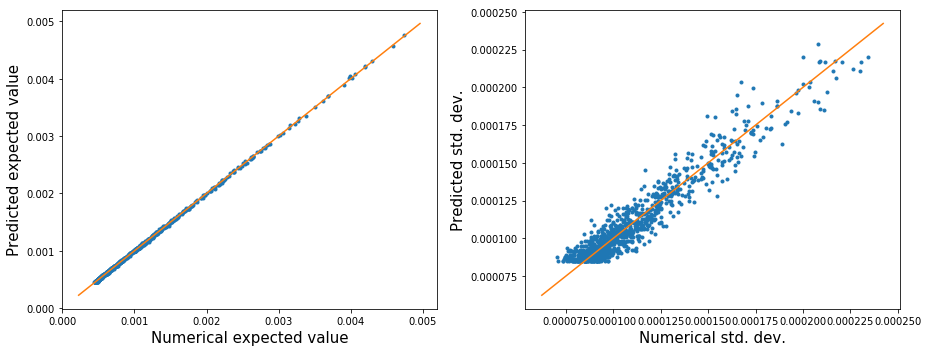

In [66]:
plt.figure(figsize=[13,5])
plt.subplot(121)
plt.plot(rdmy_ms.mean(axis=1),mu,'.')
plt.xlabel('Numerical expected value',fontsize=15)
plt.ylabel('Predicted expected value',fontsize=15)
plt.plot(plt.xlim(),plt.xlim())
plt.subplot(122)
plt.plot(rdmy_ms.std(axis=1),sigma,'.')
plt.xlabel('Numerical std. dev.',fontsize=15)
plt.ylabel('Predicted std. dev.',fontsize=15)
plt.plot(plt.xlim(),plt.xlim())
plt.tight_layout()

# Other random shit

In [104]:
def func(adj,x,lambd):
    p = adj / np.reshape(adj.sum(axis=0), [adj.shape[0],1])
    I = np.eye(p.shape[0])
    return lambd*x.dot(np.linalg.inv(I - (1-lambd)*p))

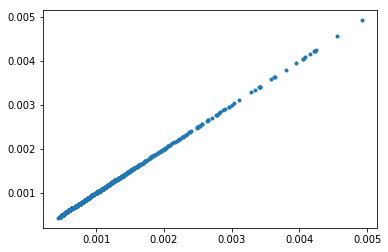

In [113]:
plt.plot(propagate(m.adj_matrix,x,lambd),func(m.adj_matrix,x,lambd),'.')

In [105]:
func(adj,x,lambd)

DeviceArray([0.00220501, 0.00104666, 0.00156459, 0.00165449, 0.0022501 ,
             0.00125103, 0.00177797, 0.00153732, 0.00108008, 0.00112426,
             0.00151228, 0.002069  , 0.00136746, 0.00241917, 0.00137094,
             0.00221037, 0.00229724, 0.00194576, 0.00242124, 0.00129274,
             0.00253923, 0.00188494, 0.00252199, 0.00042536, 0.00183439,
             0.00213165, 0.00120976, 0.00197518, 0.00164858, 0.00151575,
             0.00420334, 0.00391335, 0.00418307, 0.00351467, 0.00398858,
             0.00450292, 0.00478635, 0.00365344, 0.00399234, 0.00345062,
             0.00410198, 0.0033372 , 0.0032509 , 0.00286489, 0.00392873,
             0.00408928, 0.00351834, 0.00337108, 0.0034404 , 0.00264664,
             0.00423485, 0.00359132, 0.00282122, 0.00283174, 0.00246142,
             0.00307151, 0.00318572, 0.00328965, 0.00304954, 0.00184643,
             0.00298164, 0.00248292, 0.00277081, 0.00292581, 0.00262108,
             0.00231413, 0.00170037, 0.00243394, 0.

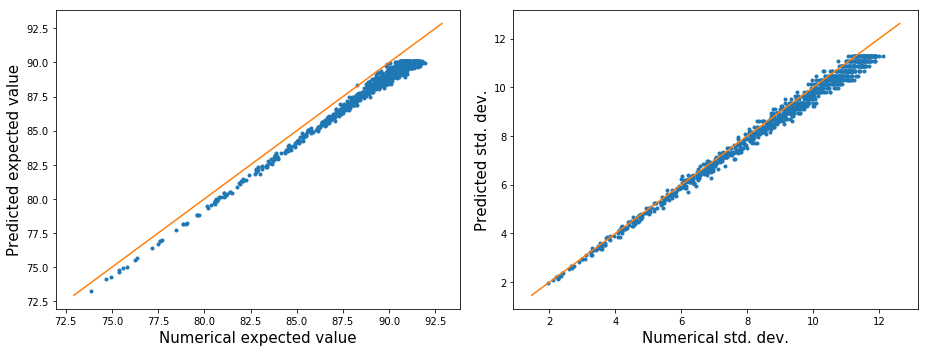

In [79]:
plt.figure(figsize=[13,5])
plt.subplot(121)
plt.plot(rdm_annd.mean(axis=1),mu,'.')
plt.xlabel('Numerical expected value',fontsize=15)
plt.ylabel('Predicted expected value',fontsize=15)
plt.plot(plt.xlim(),plt.xlim())
plt.subplot(122)
plt.plot(rdm_annd.std(axis=1),sigma,'.')
plt.xlabel('Numerical std. dev.',fontsize=15)
plt.ylabel('Predicted std. dev.',fontsize=15)
plt.plot(plt.xlim(),plt.xlim())
plt.tight_layout()

NameError: name 'rdmy_ms' is not defined

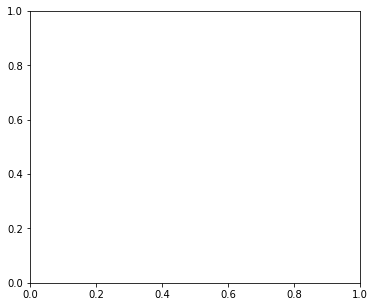

In [15]:
plt.figure(figsize=[13,5])
plt.subplot(121)
plt.plot(rdmy_ms.mean(axis=1),mu,'.')
plt.xlabel('Numerical expected value',fontsize=15)
plt.ylabel('Predicted expected value',fontsize=15)
plt.plot(plt.xlim(),plt.xlim())
plt.subplot(122)
plt.plot(rdmy_ms.std(axis=1),sigma,'.')
plt.xlabel('Numerical std. dev.',fontsize=15)
plt.ylabel('Predicted std. dev.',fontsize=15)
plt.plot(plt.xlim(),plt.xlim())
plt.tight_layout()

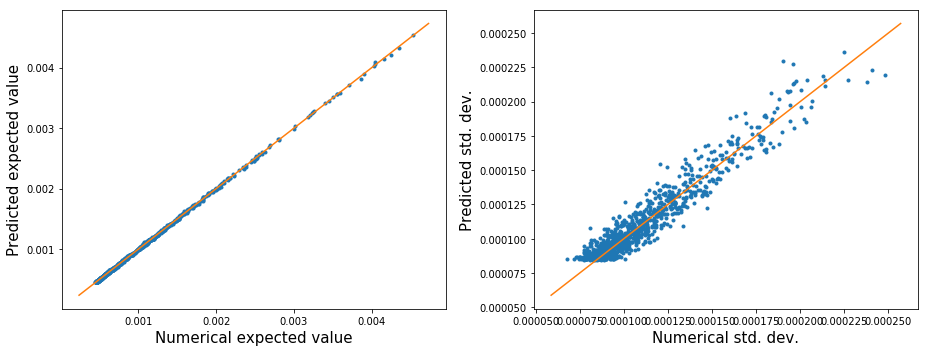

In [23]:
plt.figure(figsize=[13,5])
plt.subplot(121)
plt.plot(rdmy_ms.mean(axis=1),mu,'.')
plt.xlabel('Numerical expected value',fontsize=15)
plt.ylabel('Predicted expected value',fontsize=15)
plt.plot(plt.xlim(),plt.xlim())
plt.subplot(122)
plt.plot(rdmy_ms.std(axis=1),sigma,'.')
plt.xlabel('Numerical std. dev.',fontsize=15)
plt.ylabel('Predicted std. dev.',fontsize=15)
plt.plot(plt.xlim(),plt.xlim())
plt.tight_layout()